## Import and Load

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# seeds 
seed = 12341
np.random.seed(seed)
torch.manual_seed(seed)

In [23]:
train = pd.read_csv("data/ml-25m/ratings.csv").dropna().head(10000)
train['rating'] = train['rating'] / train['rating'].max()

train['user_id_for_model'] = train['userId'].astype('category').cat.codes
train['movie_id_for_model'] = train['movieId'].astype('category').cat.codes

train.head()

,userId,movieId,rating,timestamp,user_id_for_model,movie_id_for_model
0,1,296,1.0,1147880044,0,163
1,1,306,0.7,1147868817,0,167
2,1,307,1.0,1147868828,0,168
3,1,665,1.0,1147878820,0,352
4,1,899,0.7,1147868510,0,422


## PMF

In [50]:
from numpy.random import RandomState

class PMF(nn.Module):
	def __init__(self, n_users, n_items, n_factors=20, is_sparse=False, no_cuda=None):
		super(PMF, self).__init__()
		self.n_users = n_users
		self.n_items = n_items
		self.n_factors = n_factors
		self.random_state = RandomState(1)

		# M,D
		self.user_embeddings = nn.Embedding(n_users, n_factors, sparse=is_sparse)
		self.user_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_users, n_factors)).float()
		
		# NxD
		self.item_embeddings = nn.Embedding(n_items, n_factors, sparse=is_sparse)
		self.item_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_items, n_factors)).float()


		self.relu = nn.ReLU()
	
	def forward(self, users_index=None, items_index=None):
		if users_index is not None and items_index is not None:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			R_h = torch.dot(user_h1, item_h1)
		else:
			R_h = self.item_embeddings.weight.data @ self.user_embeddings.weight.data.T
		return nn.functional.sigmoid(R_h)

	def __call__(self, *args):
		return self.forward(*args)


	def predict(self, users_index=None, items_index=None):
		# preds = self.forward(users_index, items_index)
		if users_index and items_index:
			preds = self.forward(users_index, items_index)
		else:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			preds = (user_h1 * item_h1).sum(1)
		return preds


def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


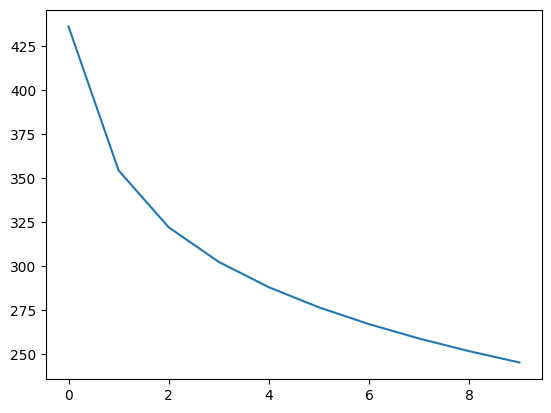

In [63]:
model = PMF(n_users=train['user_id_for_model'].max() + 1, n_items=train['movie_id_for_model'].max() + 1, n_factors=2)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

for i in range(epochs):
    print("epoch", i + 1)
    interim = 0
    
    for _, row in train.iterrows():
      user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
      # making a pridiction in forward pass
      y_hat = model.forward(users_index=user, items_index=item)
      error = row['rating'] - y_hat

      interim += np.square(error.detach().numpy())
      
      # updates
      # Pi ← Pi + α(eij Qj − λPi ) 
      model.user_embeddings.weight.data[user, :] = \
        model.user_embeddings.weight.data[user, :] + \
        lr * (error * model.item_embeddings.weight.data[item, :] - reg * model.user_embeddings.weight.data[user, :])
      # Qj ← Qj + α(eij Pi − λQj )
      model.item_embeddings.weight.data[item, :] = \
        model.item_embeddings.weight.data[item, :] + \
        lr * (error * model.user_embeddings.weight.data[user, :] - reg * model.item_embeddings.weight.data[item, :])
    loss_SGD.append(interim)

plt.plot(loss_SGD)

In [73]:
preds = []
for _, row in train.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(model.forward(users_index=user, items_index=item).detach().numpy())

len(preds)

10000

In [76]:
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse(train['rating'], np.array(preds))

0.1543629807374657

## TempMF

In [9]:
from numpy.random import RandomState

class TempMF(nn.Module):
	def __init__(self, n_users, t_steps, item_embeddings, n_factors=20, is_sparse=False, no_cuda=None):
		super(TempMF, self).__init__()
		self.n_users = n_users

		self.n_factors = n_factors
		self.random_state = RandomState(1)

		# M,D,t
		# self.user_embeddings = nn.Embedding(n_users, n_factors, t_steps, sparse=is_sparse)
		# self.user_embeddings.weight.data = torch.from_numpy(0.1 * self.random_state.rand(n_users, n_factors)).float()
		self.user_embeddings = torch.zeros([n_users, n_factors, t_steps])

		# N,D
		self.item_embeddings = item_embeddings

		self.relu = nn.ReLU()
	
	def forward(self, time_index, users_index=None, items_index=None):
		if users_index!=None and items_index!=None:
			# user_h1 = self.user_embeddings.weight.data[users_index,:,time_index]
			user_h1 = self.user_embeddings[users_index,:,time_index]
			item_h1 = self.item_embeddings(items_index)
			# print(user_h1.shape)
			# print(item_h1.shape)
			# R_h = (user_h1 * item_h1).sum(1)
			R_h = torch.dot(user_h1, item_h1)
		else:
			# R_h = self.item_embeddings.weight.data @ self.user_embeddings.weight.data[:,:,time_index].T
			R_h = self.item_embeddings.weight.data @ self.user_embeddings[:,:,time_index].T
		return R_h

	def __call__(self, *args):
		return self.forward(*args)


	def predict(self, time_index, users_index=None, items_index=None):
		preds = self.forward(time_index, users_index, items_index)
		return preds

In [10]:
tempMF = TempMF(n_users=model.n_users, t_steps=time_steps, item_embeddings=model.item_embeddings, n_factors=model.n_factors)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

# time
for t in range(time_steps):
    print("time:", t + 1)
    tempMF.user_embeddings[:,:,t] = model.user_embeddings.weight.data

    # iterations
    for iter in range(epochs):
      print(f"Epoch {iter}")
      interim = 0

      # ratings
      for _, row in train_updated[train_updated['bin'] == t].iterrows():
        user, item = torch.tensor(int(row['userId']) - 1), torch.tensor(int(row['movieId']) - 1)
        # making a pridiction in forward pass
        y_hat = tempMF.forward(time_index=t, users_index=user, items_index=item)
        error = y_hat - row['rating']
        interim += np.square(error.detach().numpy())
        
        tempMF.user_embeddings[user, :, t] = \
          tempMF.user_embeddings[user, :, t] + \
          lr * (error * tempMF.item_embeddings.weight.data[item, :] - reg * tempMF.user_embeddings[user, :, t])
      loss_SGD.append(error)


time: 1
time: 2
time: 3
time: 4
time: 5
time: 6
time: 7
time: 8
time: 9
time: 10
time: 11
time: 12
time: 13
time: 14
time: 15
time: 16
time: 17
time: 18
time: 19
time: 20
time: 21
time: 22
time: 23
time: 24
time: 25
time: 26
time: 27
time: 28
time: 29
time: 30
time: 31
time: 32
time: 33
time: 34
time: 35
time: 36
time: 37
time: 38
time: 39
time: 40
time: 41
time: 42
time: 43
time: 44
time: 45
time: 46
time: 47
time: 48
time: 49
time: 50
time: 51
time: 52
time: 53
time: 54
time: 55
time: 56
time: 57
time: 58
time: 59
time: 60
time: 61
time: 62
time: 63
time: 64
time: 65
time: 66
time: 67
time: 68
time: 69
time: 70
time: 71
time: 72
time: 73
time: 74
time: 75
time: 76
time: 77
time: 78
time: 79
time: 80
time: 81
time: 82
time: 83
time: 84
time: 85
time: 86
time: 87
time: 88
time: 89
time: 90
time: 91
time: 92
time: 93
time: 94
time: 95
time: 96
time: 97
time: 98
time: 99
time: 100


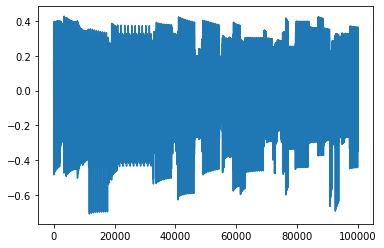

In [11]:
plt.plot(loss_SGD)

#### Lasso Regression: Drift

In [12]:
from sklearn import linear_model

In [13]:
Z_t = torch.zeros([tempMF.n_users, tempMF.n_factors, time_steps - 1])
for i in range(time_steps - 1):
    Z_t[:,:,i] = tempMF.user_embeddings[:,:,i+1] - tempMF.user_embeddings[:,:,i]
Z_t

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0255,  0.0255],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [17]:
# (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

clf = linear_model.Lasso(alpha=0.01, copy_X=True)

y = Z_t.detach()
X = tempMF.user_embeddings[:,:,1:].detach()

print(y.shape)
print(X.shape)

# clf.fit(X=X,y=y)


torch.Size([75, 20, 99])
torch.Size([75, 20, 99])


In [18]:
#Initializing weights and biases
A = torch.randn(tempMF.n_factors, tempMF.n_factors, requires_grad=True)
b = torch.randn(tempMF.n_factors, requires_grad=True)

# Define the model
def model(x):
    return torch.einsum('idt,dd->idt', x, A) + b[:, None]

# regularization parameter
reg = 0.01
lr = 1e-4

#MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff*diff)/(2 * diff.shape[-1]) + reg * torch.norm(A, 1)

losses = []


# Train for 100 epochs
for i in range(250):
    print("epoch: ", i+1)
    preds = model(X)
    loss = mse(preds, y)
    losses.append(loss)
    if i == 0:
        loss.backward(retain_graph=True)
    else:
        loss.backward()
    with torch.no_grad():
        A -= A.grad * lr
        b -= b.grad * lr
        A.grad.zero_()
        b.grad.zero_()

# Calculate loss
preds = model(X)
loss = mse(preds, y)
print(loss)

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  91
epoch:  

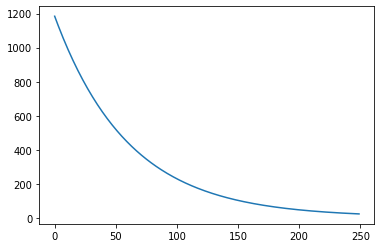

In [19]:
plt.plot(losses)